In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

import gegravity as ge
import pandas as pd
import gme as gme

pd.set_option('display.max_columns', None)


In [5]:
df = pd.read_csv('Gravity_V202211.csv')


/var/folders/gf/x21_n30n2l13jz3jhcfzjc_40000gn/T/ipykernel_65915/3543686427.py:1: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Gravity_V202211.csv')


In [293]:
df=df[df['year']==2020]
df['country_id_o']=df['country_id_o'].map(lambda x: x.replace('.2',''))
df['country_id_d']=df['country_id_d'].map(lambda x: x.replace('.2',''))
df['tz_dist']=(df['gmt_offset_2020_o']-df['gmt_offset_2020_d']).map(abs)
df['log_sci']=df['scaled_sci_2021'].map(np.log1p)
df['log_baci']=df['tradeflow_baci'].map(np.log1p)
df=df[~df['dist'].isnull()]
df['lndist']=df['distw_harmonic'].map(np.log1p)

#drop missing
df=df[~df['scaled_sci_2021'].isnull()]
df=df[~df['tradeflow_baci'].isnull()]

In [298]:
gme_data = gme.EstimationData(df, # Dataset
                          imp_var_name="country_id_o", # Importer column name
                            exp_var_name="country_id_d", # Exporter column name
                               year_var_name = "year",  # Year column name
                               trade_var_name="tradeflow_baci")  # Trade column name
gme_model = gme.EstimationModel(gme_data, # Specify data to use
                                 lhs_var="tradeflow_baci",                         
                              rhs_var=["lndist",'tz_dist'],
                              fixed_effects=[["country_id_o"],["country_id_d"]])
gme_model.estimate()
print(gme_model.results_dict['all'].summary())

Estimation began at 03:05 PM  on Jan 19, 2024
Omitted Regressors: ['country_id_d_fe_ZWE']
Estimation completed at 03:06 PM  on Jan 19, 2024
                 Generalized Linear Model Regression Results                  
Dep. Variable:         tradeflow_baci   No. Observations:                22469
Model:                            GLM   Df Residuals:                    22118
Model Family:                 Poisson   Df Model:                          350
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5917e+09
Date:                Fri, 19 Jan 2024   Deviance:                   5.1833e+09
Time:                        15:06:06   Pearson chi2:                 9.58e+09
No. Iterations:                    14   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [

/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/gme/estimate/_ppml_estimation_and_diagnostics.py:306: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diagnostics = overfit_column.append(exclusion_column)


In [299]:
gme_data = gme.EstimationData(df, # Dataset
                          imp_var_name="country_id_o", # Importer column name
                            exp_var_name="country_id_d", # Exporter column name
                               year_var_name = "year",  # Year column name
                               trade_var_name="scaled_sci_2021")  # Trade column name

gme_model2 = gme.EstimationModel(gme_data, # Specify data to use
                                 lhs_var="scaled_sci_2021",                         
                              rhs_var=["lndist",'tz_dist'],
                              fixed_effects=[["country_id_o"],["country_id_d"]])

gme_model2.estimate()
print(gme_model2.results_dict['all'].summary())

Estimation began at 03:06 PM  on Jan 19, 2024
Omitted Regressors: ['country_id_d_fe_ZWE']
Estimation completed at 03:06 PM  on Jan 19, 2024
                 Generalized Linear Model Regression Results                  
Dep. Variable:        scaled_sci_2021   No. Observations:                22469
Model:                            GLM   Df Residuals:                    22118
Model Family:                 Poisson   Df Model:                          350
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.2371e+08
Date:                Fri, 19 Jan 2024   Deviance:                   6.4721e+08
Time:                        15:06:21   Pearson chi2:                 1.56e+09
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [

/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/gme/estimate/_ppml_estimation_and_diagnostics.py:306: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diagnostics = overfit_column.append(exclusion_column)


In [281]:
#git data

import country_converter as coco
gh = pd.read_csv('../economy_collaborators.csv')
iso2_to_3=dict(zip(gh.source.unique(),coco.convert(gh.source.unique(),to='ISO3')))
gh['source']=gh['source'].map(iso2_to_3)
gh['destination']=gh['destination'].map(iso2_to_3)
gh=gh[gh['source']!='not found']
gh=gh[gh['destination']!='not found']
gh=gh.groupby(['year','source','destination'])['weight'].mean().\
    unstack(1).fillna(0).stack().reset_index()
gh=gh[gh['year']==2020]
gh.columns = ['year','country_id_o','country_id_d','gh_vol']

nan not found in ISO3
EU not found in ISO2


In [285]:
df2=pd.merge(df,gh,on=['year','country_id_o','country_id_d'],how='inner')
#df2=df2.fillna(0)

In [300]:
df2.gh_vol

0          0.0
1          0.0
2          0.0
3          0.0
4        807.0
         ...  
17730      0.0
17731      0.0
17732      0.0
17733      0.0
17734    192.0
Name: gh_vol, Length: 17735, dtype: float64

In [301]:
gme_data = gme.EstimationData(df2, # Dataset
                          imp_var_name="country_id_o", # Importer column name
                            exp_var_name="country_id_d", # Exporter column name
                               year_var_name = "year",  # Year column name
                               trade_var_name="gh_vol")  # Trade column name

gme_model2 = gme.EstimationModel(gme_data, # Specify data to use
                                 lhs_var="gh_vol",                         
                              rhs_var=["lndist",'tz_dist'],
                              fixed_effects=[["country_id_o"],["country_id_d"]])

gme_model2.estimate()
print(gme_model2.results_dict['all'].summary())

Estimation began at 03:07 PM  on Jan 19, 2024


/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/gme/estimate/_ppml_estimation_and_diagnostics.py:254: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  adjusted_data_frame.drop(col, 1, inplace=True)


Omitted Regressors: ['country_id_o_fe_GRD', 'country_id_d_fe_ATG', 'country_id_d_fe_BFA', 'country_id_d_fe_BWA', 'country_id_d_fe_COG', 'country_id_d_fe_DJI', 'country_id_d_fe_GUM', 'country_id_d_fe_HTI', 'country_id_d_fe_LBR', 'country_id_d_fe_LBY', 'country_id_d_fe_MRT', 'country_id_d_fe_SLE', 'country_id_d_fe_SUR', 'country_id_d_fe_TGO', 'country_id_d_fe_TJK', 'country_id_d_fe_WSM', 'country_id_d_fe_ZWE']
Estimation completed at 03:07 PM  on Jan 19, 2024
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 gh_vol   No. Observations:                16354
Model:                            GLM   Df Residuals:                    16077
Model Family:                 Poisson   Df Model:                          276
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.5052e+05
Date:                Fri, 19 Jan 2024   Deviance:               

/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/gme/estimate/_ppml_estimation_and_diagnostics.py:306: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diagnostics = overfit_column.append(exclusion_column)


In [302]:
gme_data = gme.EstimationData(df2, # Dataset
                          imp_var_name="country_id_o", # Importer column name
                            exp_var_name="country_id_d", # Exporter column name
                               year_var_name = "year",  # Year column name
                               trade_var_name="tradeflow_baci")  # Trade column name

gme_model2 = gme.EstimationModel(gme_data, # Specify data to use
                                 lhs_var="tradeflow_baci",                         
                              rhs_var=["lndist",'tz_dist'],
                              fixed_effects=[["country_id_o"],["country_id_d"]])

gme_model2.estimate()
print(gme_model2.results_dict['all'].summary())

Estimation began at 03:07 PM  on Jan 19, 2024
Omitted Regressors: ['country_id_d_fe_ZWE']
Estimation completed at 03:07 PM  on Jan 19, 2024
                 Generalized Linear Model Regression Results                  
Dep. Variable:         tradeflow_baci   No. Observations:                17735
Model:                            GLM   Df Residuals:                    17442
Model Family:                 Poisson   Df Model:                          292
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4218e+09
Date:                Fri, 19 Jan 2024   Deviance:                   4.8435e+09
Time:                        15:07:32   Pearson chi2:                 7.65e+09
No. Iterations:                    13   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [

/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/gme/estimate/_ppml_estimation_and_diagnostics.py:306: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diagnostics = overfit_column.append(exclusion_column)


In [303]:
gme_data = gme.EstimationData(df2, # Dataset
                          imp_var_name="country_id_o", # Importer column name
                            exp_var_name="country_id_d", # Exporter column name
                               year_var_name = "year",  # Year column name
                               trade_var_name="scaled_sci_2021")  # Trade column name

gme_model2 = gme.EstimationModel(gme_data, # Specify data to use
                                 lhs_var="scaled_sci_2021",                         
                              rhs_var=["lndist",'tz_dist'],
                              fixed_effects=[["country_id_o"],["country_id_d"]])

gme_model2.estimate()
print(gme_model2.results_dict['all'].summary())

Estimation began at 03:07 PM  on Jan 19, 2024
Omitted Regressors: ['country_id_d_fe_ZWE']
Estimation completed at 03:07 PM  on Jan 19, 2024
                 Generalized Linear Model Regression Results                  
Dep. Variable:        scaled_sci_2021   No. Observations:                17735
Model:                            GLM   Df Residuals:                    17442
Model Family:                 Poisson   Df Model:                          292
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9164e+08
Date:                Fri, 19 Jan 2024   Deviance:                   3.8312e+08
Time:                        15:07:42   Pearson chi2:                 9.83e+08
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [

/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/gme/estimate/_ppml_estimation_and_diagnostics.py:306: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diagnostics = overfit_column.append(exclusion_column)


In [219]:
df3[df3['gh_vol']==0]

,year,country_id_o,country_id_d,iso3_o,iso3_d,iso3num_o,iso3num_d,country_exists_o,country_exists_d,gmt_offset_2020_o,gmt_offset_2020_d,distw_harmonic,distw_arithmetic,distw_harmonic_jh,distw_arithmetic_jh,dist,main_city_source_o,main_city_source_d,distcap,contig,diplo_disagreement,scaled_sci_2021,comlang_off,comlang_ethno,comcol,col45,legal_old_o,legal_old_d,legal_new_o,legal_new_d,comleg_pretrans,comleg_posttrans,transition_legalchange,comrelig,heg_o,heg_d,col_dep_ever,col_dep,col_dep_end_year,col_dep_end_conflict,empire,sibling_ever,sibling,sever_year,sib_conflict,pop_o,pop_d,gdp_o,gdp_d,gdpcap_o,gdpcap_d,pop_source_o,pop_source_d,gdp_source_o,gdp_source_d,gdp_ppp_o,gdp_ppp_d,gdpcap_ppp_o,gdpcap_ppp_d,pop_pwt_o,pop_pwt_d,gdp_ppp_pwt_o,gdp_ppp_pwt_d,gatt_o,gatt_d,wto_o,wto_d,eu_o,eu_d,fta_wto,fta_wto_raw,rta_coverage,rta_type,entry_cost_o,entry_cost_d,entry_proc_o,entry_proc_d,entry_time_o,entry_time_d,entry_tp_o,entry_tp_d,tradeflow_comtrade_o,tradeflow_comtrade_d,tradeflow_baci,manuf_tradeflow_baci,tradeflow_imf_o,tradeflow_imf_d,lndist,tz_dist,log_sci,gh_vol
940,2020,ALB,ABW,ALB,ABW,8.0,533.0,1.0,1.0,1.0,-4.0,9090.0,9090.0,NaN,NaN,9090.0,UN_WUP_Largest,UN_WUP_Capitals,9090.0,0.0,NaN,1849.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2837.849,106.766,1.513187e+07,2.496648e+06,5.332,23.384,NaN,NaN,NaN,NaN,3.868609e+07,3.329266e+06,13.632,31.183,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.114930,5.0,7.522400,0.0
942,2020,ALB,AGO,ALB,AGO,8.0,24.0,1.0,1.0,1.0,1.0,5669.0,5679.0,NaN,NaN,5595.0,UN_WUP_Largest,UN_WUP_Largest,5595.0,0.0,1.641,994.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2837.849,32866.268,1.513187e+07,5.361907e+07,5.332,1.631,NaN,NaN,NaN,NaN,3.868609e+07,2.129186e+08,13.632,6.478,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.823,NaN,NaN,NaN,NaN,5.977,8.642768,0.0,6.901737,0.0
944,2020,ALB,ALB,ALB,ALB,8.0,8.0,1.0,1.0,1.0,1.0,8.0,8.0,NaN,NaN,64.0,WB_Area,WB_Area,64.0,0.0,NaN,16798680.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.042,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2837.849,2837.849,1.513187e+07,1.513187e+07,5.332,5.332,NaN,NaN,NaN,NaN,3.868609e+07,3.868609e+07,13.632,13.632,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.079442,0.0,16.636811,0.0
946,2020,ALB,ARE,ALB,ARE,8.0,784.0,1.0,1.0,1.0,4.0,3724.0,3724.0,NaN,NaN,3718.0,UN_WUP_Largest,UN_WUP_Largest,3698.0,0.0,1.817,2519.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,2.0,0.0,0.0,0.0,0.195,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2837.849,9890.400,1.513187e+07,3.588688e+08,5.332,36.285,NaN,NaN,NaN,NaN,3.868609e+07,6.603430e+08,13.632,66.766,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7597.796,4632.821,11250.189,4213.214,8216.608,4632.837,8.222554,3.0,7.831617,0.0
947,2020,ALB,ARG,ALB,ARG,8.0,32.0,1.0,1.0,1.0,-3.0,11628.0,11633.0,NaN,NaN,11592.0,UN_WUP_Largest,UN_WUP_Largest,11592.0,0.0,1.177,704.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2837.849,45376.762,1.513187e+07,3.895910e+08,5.332,8.586,NaN,NaN,NaN,NaN,3.868609e+07,9.424315e+08,13.632,20.769,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,396.375,393.278,364.140,NaN,397.000,9.361171,4.0,6.556778,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54742,2020,ZAF,UZB,ZAF,UZB,710.0,860.0,1.0,1.0,2.0,5.0,8821.0,8847.0,NaN,NaN,8592.0,UN_WUP_Largest,UN_WUP_Largest,8541.0,0.0,0.254

In [306]:
df3 = df2[~df2['lndist'].isnull()]
df3 = df3[~df3['log_sci'].isnull()]
df3 = df3[~df3['gdp_o'].isnull()]
df3 = df3[~df3['gdp_d'].isnull()]
df3 = df3[~df3['gh_vol'].isnull()]
df3 = df3[~df3['tradeflow_baci'].isnull()]
df3['log_gh_vol'] = df3['gh_vol'].map(lambda x: np.log(x+1))
df3['log_tradeflow_baci'] = df3['tradeflow_baci'].map(lambda x: np.log(x+1))
df3['log_gdp_o'] = df3['gdp_o'].map(lambda x: np.log(x+1))
df3['log_gdp_d'] = df3['gdp_d'].map(lambda x: np.log(x+1))

In [308]:
df3

,year,country_id_o,country_id_d,iso3_o,iso3_d,iso3num_o,iso3num_d,country_exists_o,country_exists_d,gmt_offset_2020_o,gmt_offset_2020_d,distw_harmonic,distw_arithmetic,distw_harmonic_jh,distw_arithmetic_jh,dist,main_city_source_o,main_city_source_d,distcap,contig,diplo_disagreement,scaled_sci_2021,comlang_off,comlang_ethno,comcol,col45,legal_old_o,legal_old_d,legal_new_o,legal_new_d,comleg_pretrans,comleg_posttrans,transition_legalchange,comrelig,heg_o,heg_d,col_dep_ever,col_dep,col_dep_end_year,col_dep_end_conflict,empire,sibling_ever,sibling,sever_year,sib_conflict,pop_o,pop_d,gdp_o,gdp_d,gdpcap_o,gdpcap_d,pop_source_o,pop_source_d,gdp_source_o,gdp_source_d,gdp_ppp_o,gdp_ppp_d,gdpcap_ppp_o,gdpcap_ppp_d,pop_pwt_o,pop_pwt_d,gdp_ppp_pwt_o,gdp_ppp_pwt_d,gatt_o,gatt_d,wto_o,wto_d,eu_o,eu_d,fta_wto,fta_wto_raw,rta_coverage,rta_type,entry_cost_o,entry_cost_d,entry_proc_o,entry_proc_d,entry_time_o,entry_time_d,entry_tp_o,entry_tp_d,tradeflow_comtrade_o,tradeflow_comtrade_d,tradeflow_baci,manuf_tradeflow_baci,tradeflow_imf_o,tradeflow_imf_d,lndist,tz_dist,log_sci,gh_vol,log_gh_vol,log_tradeflow_baci,log_gdp_o,log_gdp_d
0,2020,ALB,ARE,ALB,ARE,8.0,784.0,1,1,1.0,4.0,3724.0,3724.0,NaN,NaN,3718.0,UN_WUP_Largest,UN_WUP_Largest,3698.0,0.0,1.817,2519.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,2.0,0.0,0.0,0.0,0.195,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2837.849,9890.400,1.513187e+07,3.588688e+08,5.332,36.285,NaN,NaN,NaN,NaN,3.868609e+07,6.603430e+08,13.632,66.766,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7597.796,4632.821,11250.189,4213.214,8216.608,4632.837,8.222554,3.0,7.831617,0.0,0.000000,9.328229,16.532313,19.698467
1,2020,ALB,ARG,ALB,ARG,8.0,32.0,1,1,1.0,-3.0,11628.0,11633.0,NaN,NaN,11592.0,UN_WUP_Largest,UN_WUP_Largest,11592.0,0.0,1.177,704.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2837.849,45376.762,1.513187e+07,3.895910e+08,5.332,8.586,NaN,NaN,NaN,NaN,3.868609e+07,9.424315e+08,13.632,20.769,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,396.375,393.278,364.140,NaN,397.000,9.361171,4.0,6.556778,0.0,0.000000,5.977056,16.532313,19.780608
2,2020,ALB,ARM,ALB,ARM,8.0,51.0,1,1,1.0,4.0,2082.0,2082.0,NaN,NaN,2082.0,UN_WUP_Largest,UN_WUP_Largest,2082.0,0.0,0.871,989.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,1900.0,0.0,2837.849,2963.234,1.513187e+07,1.264121e+07,5.332,4.266,NaN,NaN,NaN,NaN,3.868609e+07,3.944369e+07,13.632,13.311,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.597,1183.883,1174.853,1174.853,132.583,1184.328,7.641084,3.0,6.896694,0.0,0.000000,7.069749,16.532313,16.352473
3,2020,ALB,AUS,ALB,AUS,8.0,36.0,1,1,1.0,10.0,15113.0,15174.0,NaN,NaN,15371.0,UN_WUP_Largest,UN_WUP_Largest,15602.0,0.0,0.305,2671.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,2.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2837.849,25693.268,1.513187e+07,1.327836e+09,5.332,51.680,NaN,NaN,NaN,NaN,3.868609e+07,1.369885e+09,13.632,53.317,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1825.814,2673.924,2530.835,2265.225,1974.522,2617.149,9.623311,9.0,7.890208,0.0,0.000000,7.836700,16.532313,21.006817
4,2020,ALB,AUT,ALB,AUT,8.0,40.0,1,1,1.0,1.0,811.0,811.0,NaN,NaN,811.0,UN_WUP_Largest,UN_WUP_Largest,811.0,0.0,0.310,22361.0,0.0,0.0,0.0,0.0,2.0,4.0,1.0,3.0,0.0,0.0,0.0,0.001,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,2837.849,8916.864,1.513187e+07,4.332585e+08,5.332,48.589,NaN,NaN,NaN,NaN,3.868609e+07,4.965442e+08,13.632,55.686,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15289.718,30941.425,26700.638,24964.197,16535.010,12925.555,6.698268,0.0,10.015074,807.0,6.694562,10.192480,16.532313,19.886845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/binscatter/binscatter.py:106: UserWarning: Both fit_reg=False and non-None line_kwargs were passed.
  warnings.warn("Both fit_reg=False and non-None line_kwargs were passed.")
/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/binscatter/binscatter.py:106: UserWarning: Both fit_reg=False and non-None line_kwargs were passed.
  warnings.warn("Both fit_reg=False and non-None line_kwargs were passed.")
/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/binscatter/binscatter.py:106: UserWarning: Both fit_reg=False and non-None line_kwargs were passed.
  warnings.warn("Both fit_reg=False and non-None line_kwargs were passed.")


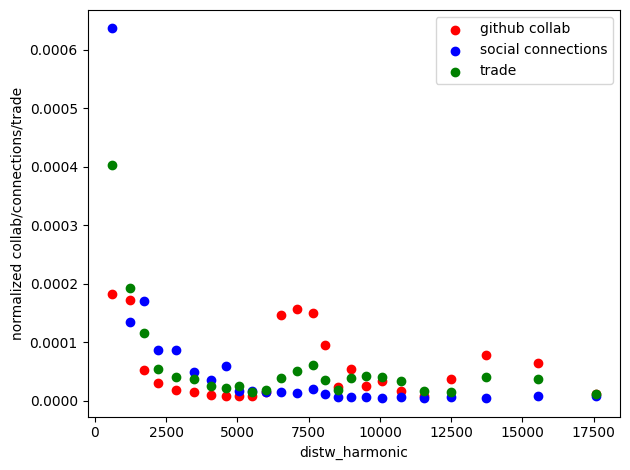

In [351]:
import binscatter
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

fig, axes = plt.subplots()
n_bins = 25
# Binned scatter plot of Wage vs Tenure
axes.binscatter(
    df3["distw_harmonic"],
    (df3["gh_vol"]/df3["gh_vol"].sum()).map(np.log1p),
    #controls=df3[["log_gdp_o","log_gdp_d"]],
    recenter_x=True,
    recenter_y=True,
    n_bins=n_bins,
    line_kwargs = {'color':'red'},
    scatter_kwargs = {'color':'red','label':'github collab'},
    fit_reg=False
)
axes.binscatter(
    df3["distw_harmonic"],
    (df3["scaled_sci_2021"]/df3["scaled_sci_2021"].sum()).map(np.log1p),
    #controls=df3[["log_gdp_o","log_gdp_d"]],
    recenter_x=True,
    recenter_y=True,
    n_bins=n_bins,
    line_kwargs = {'color':'blue'},
    scatter_kwargs = {'color':'blue','label':'social connections'},
    fit_reg=False
)
axes.binscatter(
    df3["distw_harmonic"],
    (df3["tradeflow_baci"]/df3["tradeflow_baci"].sum()).map(np.log1p),
    #controls=df3[["log_gdp_o","log_gdp_d"]],
    recenter_x=True,
    recenter_y=True,
    n_bins=n_bins,
    line_kwargs = {'color':'green'},
    scatter_kwargs = {'color':'green','label':'trade'},
    fit_reg=False
)
plt.ylabel('normalized collab/connections/trade')
plt.legend()
plt.tight_layout()
plt.show()

In [330]:
df3[(df3['country_id_o']=='USA')&(df3['country_id_d']=='IND')]

,year,country_id_o,country_id_d,iso3_o,iso3_d,iso3num_o,iso3num_d,country_exists_o,country_exists_d,gmt_offset_2020_o,gmt_offset_2020_d,distw_harmonic,distw_arithmetic,distw_harmonic_jh,distw_arithmetic_jh,dist,main_city_source_o,main_city_source_d,distcap,contig,diplo_disagreement,scaled_sci_2021,comlang_off,comlang_ethno,comcol,col45,legal_old_o,legal_old_d,legal_new_o,legal_new_d,comleg_pretrans,comleg_posttrans,transition_legalchange,comrelig,heg_o,heg_d,col_dep_ever,col_dep,col_dep_end_year,col_dep_end_conflict,empire,sibling_ever,sibling,sever_year,sib_conflict,pop_o,pop_d,gdp_o,gdp_d,gdpcap_o,gdpcap_d,pop_source_o,pop_source_d,gdp_source_o,gdp_source_d,gdp_ppp_o,gdp_ppp_d,gdpcap_ppp_o,gdpcap_ppp_d,pop_pwt_o,pop_pwt_d,gdp_ppp_pwt_o,gdp_ppp_pwt_d,gatt_o,gatt_d,wto_o,wto_d,eu_o,eu_d,fta_wto,fta_wto_raw,rta_coverage,rta_type,entry_cost_o,entry_cost_d,entry_proc_o,entry_proc_d,entry_time_o,entry_time_d,entry_tp_o,entry_tp_d,tradeflow_comtrade_o,tradeflow_comtrade_d,tradeflow_baci,manuf_tradeflow_baci,tradeflow_imf_o,tradeflow_imf_d,lndist,tz_dist,log_sci,gh_vol,log_gh_vol,log_tradeflow_baci,log_gdp_o,log_gdp_d
17254,2020,USA,IND,USA,IND,840.0,356.0,1,1,-5.0,5.5,13242.0,13306.0,NaN,NaN,11771.0,UN_WUP_Largest,UN_WUP_Largest,12064.0,0.0,2.923,955.0,1.0,1.0,0.0,0.0,3.0,3.0,2.0,2.0,1.0,1.0,0.0,0.01,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,331501.068,1380004.395,2.089374e+10,2.667688e+09,63.028,1.933,NaN,NaN,NaN,NaN,2.089374e+10,9.005119e+09,63.028,6.525,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.683948e+07,25868880.21,26711664.0,17656856.0,27394588.0,26592492.0,9.491149,10.5,6.861711,135401.75,11.816009,17.100611,23.762716,21.704478


In [350]:
np.where(df3['country_id_o']==df3['country_id_d'])

(array([], dtype=int64),)

In [343]:
len(set(list(df3['country_id_o'].unique())+list(df3['country_id_d'].unique())))

160

In [344]:
(160**2 - 160)/2

12720.0

/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/binscatter/binscatter.py:106: UserWarning: Both fit_reg=False and non-None line_kwargs were passed.
  warnings.warn("Both fit_reg=False and non-None line_kwargs were passed.")


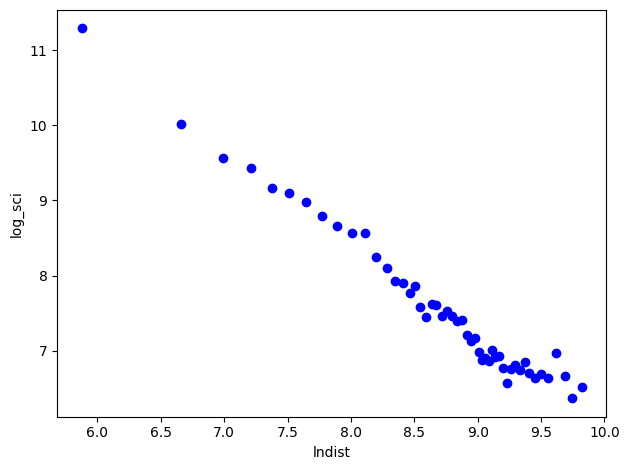

In [254]:
fig, axes = plt.subplots()

# Binned scatter plot of Wage vs Tenure
axes.binscatter(
    df3["lndist"],
    df3["log_sci"],
    controls=df3[["gdp_o","gdp_d"]],
    recenter_x=True,
    recenter_y=True,
    n_bins=50,
    line_kwargs = {'color':'blue'},
    scatter_kwargs = {'color':'blue'},
    fit_reg=False
)
# Binned scatter plot that partials out the effect of experience
#axes.binscatter(
#    df3["lndist"],
#    df3["log_sci"],
#    controls=df3[["gdp_o","gdp_d"]],
#    recenter_x=True,
#    recenter_y=True,
#)

plt.tight_layout()
plt.show()

/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/binscatter/binscatter.py:106: UserWarning: Both fit_reg=False and non-None line_kwargs were passed.
  warnings.warn("Both fit_reg=False and non-None line_kwargs were passed.")


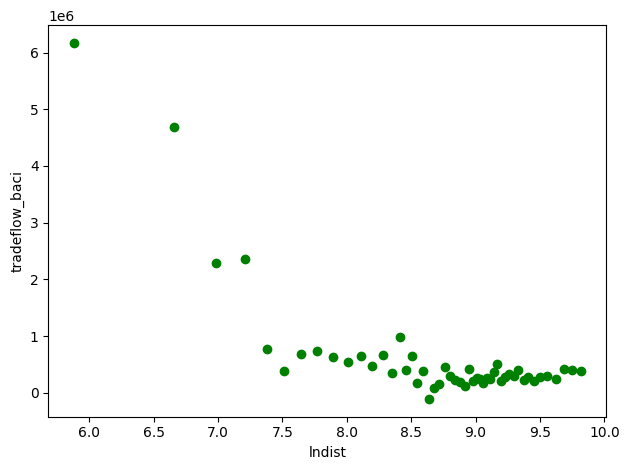

In [255]:
fig, axes = plt.subplots()

# Binned scatter plot of Wage vs Tenure
axes.binscatter(
    df3["lndist"],
    df3["tradeflow_baci"],
    controls=df3[["gdp_o","gdp_d"]],
    recenter_x=True,
    recenter_y=True,
    n_bins=50,
    line_kwargs = {'color':'green'},
    scatter_kwargs = {'color':'green'},
    fit_reg=False
)
# Binned scatter plot that partials out the effect of experience
#axes.binscatter(
#    df3["lndist"],
#    df3["log_sci"],
#    controls=df3[["gdp_o","gdp_d"]],
#    recenter_x=True,
#    recenter_y=True,
#)

plt.tight_layout()
plt.show()

/Users/johanneswachs/opt/anaconda3/lib/python3.9/site-packages/binscatter/binscatter.py:106: UserWarning: Both fit_reg=False and non-None line_kwargs were passed.
  warnings.warn("Both fit_reg=False and non-None line_kwargs were passed.")


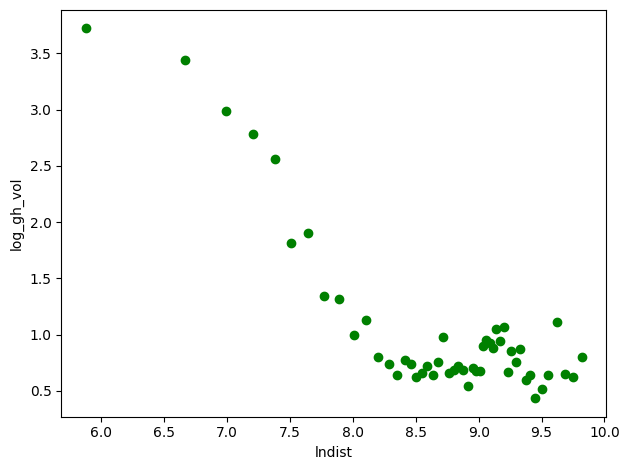

In [264]:
fig, axes = plt.subplots()

# Binned scatter plot of Wage vs Tenure
axes.binscatter(
    df3["lndist"],
    df3["log_gh_vol"],
    controls=df3[["gdp_o","gdp_d"]],
    recenter_x=True,
    recenter_y=True,
    n_bins=50,
    line_kwargs = {'color':'green'},
    scatter_kwargs = {'color':'green'},
    fit_reg=False
)
# Binned scatter plot that partials out the effect of experience
#axes.binscatter(
#    df3["lndist"],
#    df3["log_sci"],
#    controls=df3[["gdp_o","gdp_d"]],
#    recenter_x=True,
#    recenter_y=True,
#)

plt.tight_layout()
plt.show()